# Smart Agriculture Crop Prediction Model

### 1. Importing Libraries

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 54650
np.random.seed(RANDOM_STATE)


### 2. Dataset Loading

In [7]:
df = pd.read_csv("../Crop_Yield_Fertilizer.csv")  

In [8]:
print(df.shape)
df.head()

(25000, 10)


,N,P,K,temperature,humidity,ph,rainfall,label,yield,fertilizer
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,71.199428,DAP
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,81.620199,DAP
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,80.473130,Gypsum
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,75.178196,DAP
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,75.485563,Gypsum


### 3. Sanity Mandate Checks

In [9]:
# Missing values
print(df.isnull().sum())

# Crop label distribution
print(df['label'].value_counts())


N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
yield          0
fertilizer     0
dtype: int64
label
orange         1196
kidneybeans    1180
papaya         1174
maize          1168
mungbean       1164
banana         1164
chickpea       1159
rice           1149
mothbeans      1149
coconut        1145
blackgram      1145
coffee         1140
watermelon     1133
jute           1129
pigeonpeas     1122
grapes         1111
apple          1110
cotton         1108
muskmelon      1098
pomegranate    1092
lentil         1085
mango          1079
Name: count, dtype: int64


### 4. Feature / Target Selection

In [11]:
FEATURES = [
    'N', 'P', 'K',
    'temperature', 'humidity', 'ph', 'rainfall'
]

TARGET = 'label'

X = df[FEATURES]
y = df[TARGET]
# including fertilizer and yeild would result in data leakage

### 5. Encode Target Labels

In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(label_encoder.classes_)
print("Number of crop classes:", num_classes)


Number of crop classes: 22


### 6. Preprocessing Pipeline

In [13]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, FEATURES)
    ]
)


### 7. Model Selection

In [14]:
# This model is capable of non-linear nutrient interactions
# and it robust to agricultural noises
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
    # n_jobs=-1
)


### 8. Full Pipeline

In [15]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


### 9. Train-Test Split with stratification (ON)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.18,
    stratify=y_encoded,
    random_state=RANDOM_STATE
)


### 10. Model Training

In [20]:
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 11. Evaluation

In [21]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))


Accuracy: 0.9453333333333334

Classification Report:

              precision    recall  f1-score   support

       apple       0.97      0.96      0.97       200
      banana       0.99      1.00      1.00       210
   blackgram       0.85      0.88      0.87       206
    chickpea       1.00      1.00      1.00       209
     coconut       0.98      0.98      0.98       206
      coffee       0.96      0.99      0.98       205
      cotton       0.98      1.00      0.99       199
      grapes       0.97      0.97      0.97       200
        jute       0.82      0.85      0.83       203
 kidneybeans       1.00      0.99      0.99       212
      lentil       0.86      0.81      0.83       195
       maize       0.99      0.96      0.97       210
       mango       0.98      0.99      0.98       194
   mothbeans       0.93      0.90      0.91       207
    mungbean       0.94      0.97      0.96       210
   muskmelon       0.92      0.88      0.90       198
      orange       1.00    

### 12. Confusion Matrix

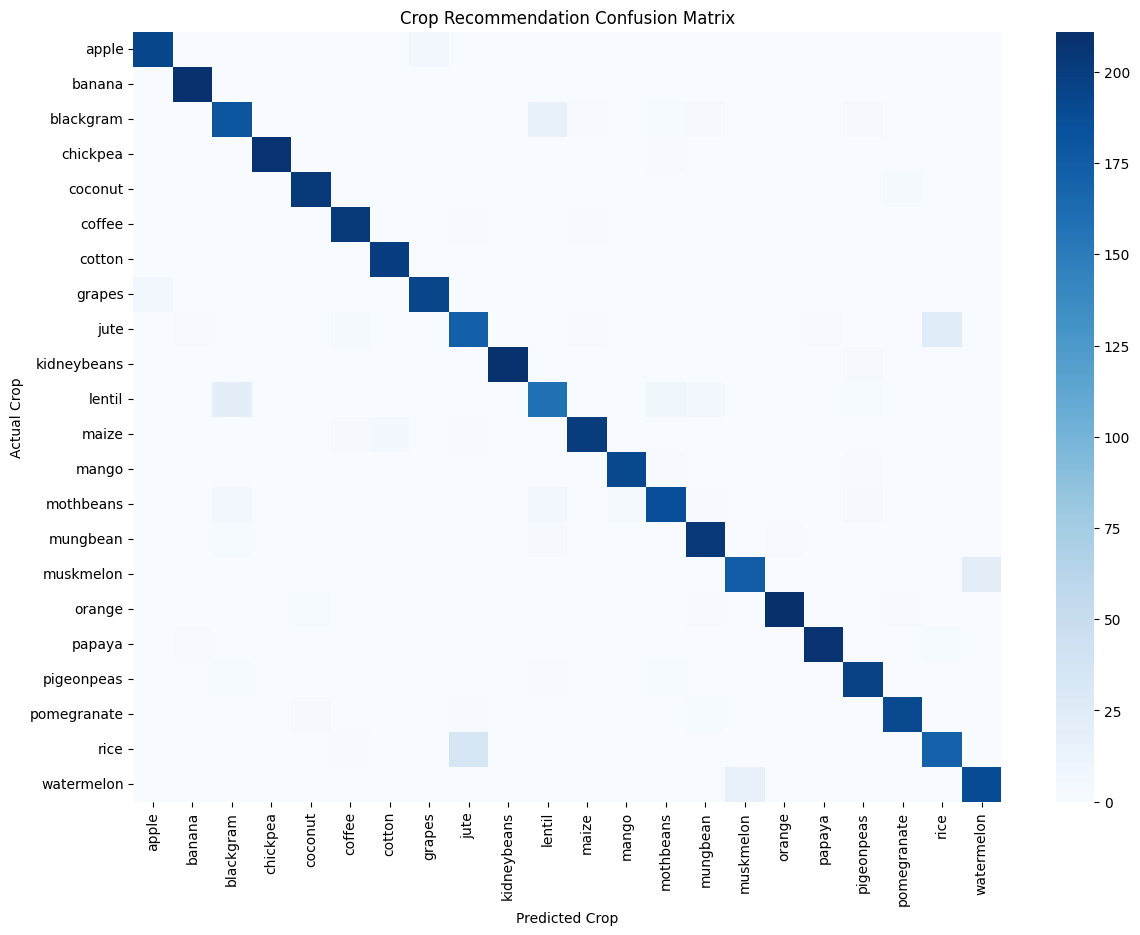

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar=True
)
plt.xlabel("Predicted Crop")
plt.ylabel("Actual Crop")
plt.title("Crop Recommendation Confusion Matrix")
plt.show()


### 13. Cross-Validation 

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

macro_f1 = cross_val_score(
    pipeline,
    X,
    y_encoded,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

print("Macro F1 scores:", macro_f1)
print("Mean Macro F1:", macro_f1.mean())


Macro F1 scores: [0.94275737 0.93925854 0.93902232 0.93789233 0.94160164]
Mean Macro F1: 0.9401064416460472


In [24]:
def recommend_crop(input_dict):
    """
    input_dict example:
    {
        'N': 90,
        'P': 42,
        'K': 43,
        'temperature': 26,
        'humidity': 80,
        'ph': 6.5,
        'rainfall': 200
    }
    """
    input_df = pd.DataFrame([input_dict])
    pred_encoded = pipeline.predict(input_df)[0]
    return label_encoder.inverse_transform([pred_encoded])[0]


In [26]:
sample_input = {
    'N': 10,
    'P': 10,
    'K': 43,
    'temperature': 10,
    'humidity': 89,
    'ph': 6.5,
    'rainfall': 45
}

print("Recommended Crop:", recommend_crop(sample_input))


Recommended Crop: pomegranate
